In [3]:
import os
from pathlib import Path

# Update this if 'DeepLearning' is inside another folder (like MyDrive)
base_path = '/content/drive/MyDrive/DeepLearning'

# Verify the path exists
if os.path.exists(base_path):
    print("Folder found! Proceeding...")
else:
    print("Folder not found. Check the path in your Drive.")

Folder found! Proceeding...


In [4]:
image_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

print(f"Total images found: {len(image_paths)}")

Total images found: 2160


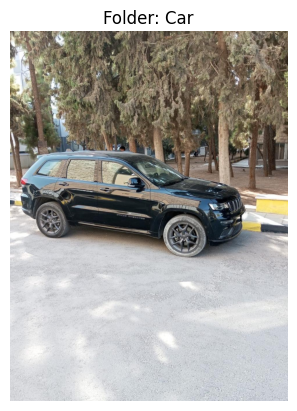

In [5]:

import matplotlib.pyplot as plt
from PIL import Image
import random

# Pick a random path from your list
random_path = random.choice(image_paths)

# Open and display it
img = Image.open(random_path)
plt.imshow(img)
plt.axis('off') # Hide the X and Y numbers/axes
plt.title(f"Folder: {random_path.split('/')[-2]}") # Shows the parent folder name
plt.show()

Images per category:
ClassName
Tree        833
Car         449
Building    338
Person      320
Lab         220
Name: count, dtype: int64


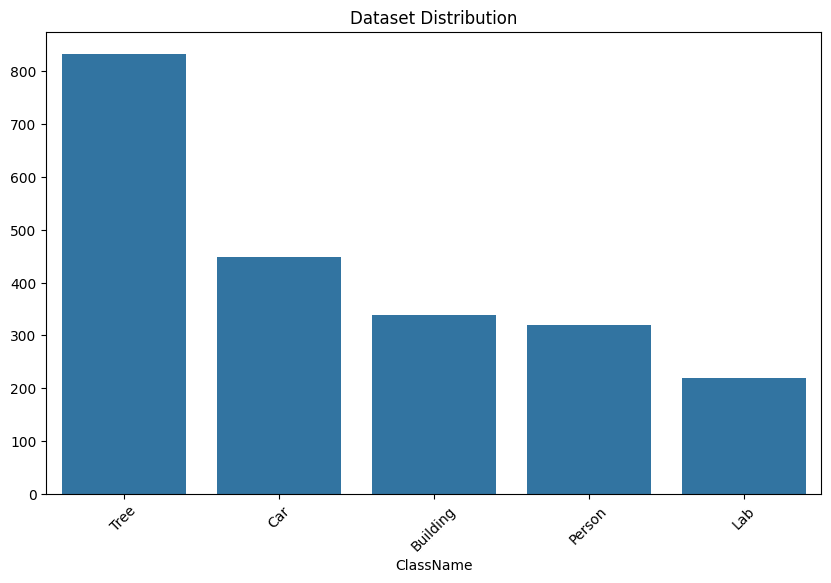

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract folder names (labels) from the paths
# Path format: /content/drive/MyDrive/DeepLearning/Car1/image.jpg
# We take the second to last element
labels = [path.split('/')[-2] for path in image_paths]

# Create a summary
df = pd.DataFrame(labels, columns=['ClassName'])
counts = df['ClassName'].value_counts()

print("Images per category:")
print(counts)

# Visualize it
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.title('Dataset Distribution')
plt.xticks(rotation=45)
plt.show()

In [7]:
import numpy as np

# Total number of images
total = sum(counts.values)
# Number of classes
num_classes = len(counts)

# Formula: total / (num_classes * count_per_class)
class_weights = {i: total / (num_classes * count) for i, count in enumerate(counts.values)}

# Let's map these weights back to the names so you can see them
weight_mapping = {name: weight for name, weight in zip(counts.index, class_weights.values())}

for name, weight in weight_mapping.items():
    print(f"Weight for {name}: {weight:.2f}")

Weight for Tree: 0.52
Weight for Car: 0.96
Weight for Building: 1.28
Weight for Person: 1.35
Weight for Lab: 1.96


In [8]:
from PIL import Image
import pandas as pd

data_info = []

# Check a sample of 100 images to save time
for path in image_paths[:100]:
    with Image.open(path) as img:
        width, height = img.size
        mode = img.mode # e.g., 'RGB', 'RGBA', 'L' (grayscale)
        ext = path.split('.')[-1].lower()
        data_info.append([width, height, mode, ext])

# Create a summary table
info_df = pd.DataFrame(data_info, columns=['Width', 'Height', 'Mode', 'Extension'])
print(info_df.describe())
print("\nImage Modes found:", info_df['Mode'].unique())

             Width       Height
count   100.000000   100.000000
mean   1910.530000  2279.570000
std    1200.806097  1253.682191
min     423.000000   596.000000
25%    1200.000000  1599.000000
50%    1200.000000  1599.000000
75%    3456.000000  2976.000000
max    5712.000000  4608.000000

Image Modes found: ['RGB']


In [9]:
import os
import tensorflow as tf
import numpy as np
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.applications.resnet import preprocess_input

# --- 1. DEFINE PATH ---
# Make sure this matches your exact folder name
base_path = '/content/drive/MyDrive/DeepLearning'

# --- 2. RE-GATHER ALL IMAGE PATHS AND LABELS ---
image_paths = []
labels = []

# This walks through your folders (Tree, Car, Building, Person, Lab)
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            image_paths.append(full_path)
            # The label is the folder name (e.g., 'Tree')
            labels.append(full_path.split('/')[-2])

print(f"✅ Found {len(image_paths)} images.")

# --- 3. SPLIT & WEIGHTS ---
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# ============================
# ✅ ADD THIS PART (BALANCE VAL)
# ============================
SEED = 42
rng = np.random.default_rng(SEED)

# keep a copy of the original val (optional, for "real" evaluation)
val_paths_orig = val_paths
val_labels_orig = val_labels

# downsample VAL to reduce Tree dominance (balanced to the smallest class in VAL)
val_paths = np.array(val_paths)
val_labels = np.array(val_labels)

classes, counts = np.unique(val_labels, return_counts=True)
target = counts.min()  # each class in VAL will have this many samples

keep_idx = []
for cls in classes:
    idx = np.where(val_labels == cls)[0]
    chosen = rng.choice(idx, size=target, replace=False)
    keep_idx.append(chosen)

keep_idx = np.concatenate(keep_idx)
rng.shuffle(keep_idx)

val_paths = val_paths[keep_idx].tolist()
val_labels = val_labels[keep_idx].tolist()

print("✅ VAL original counts:", dict(zip(*np.unique(val_labels_orig, return_counts=True))))
print("✅ VAL balanced counts:", dict(zip(*np.unique(val_labels, return_counts=True))))
# ============================
# ✅ END ADD
# ============================

unique_classes = sorted(list(set(labels)))
label_to_index = {name: i for i, name in enumerate(unique_classes)}
train_indices = [label_to_index[l] for l in train_labels]
val_indices = [label_to_index[l] for l in val_labels]

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_indices),
    y=train_indices
)
class_weight_dict = dict(enumerate(weights))

# --- 4. CREATE DATASETS ---
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_indices))
train_ds = train_ds.map(load_and_preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_indices))
val_ds = val_ds.map(load_and_preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

print("✅ Preprocessing Complete! Ready for ResNet18.")


✅ Found 2160 images.
✅ VAL original counts: {np.str_('Building'): np.int64(68), np.str_('Car'): np.int64(90), np.str_('Lab'): np.int64(44), np.str_('Person'): np.int64(64), np.str_('Tree'): np.int64(166)}
✅ VAL balanced counts: {np.str_('Building'): np.int64(44), np.str_('Car'): np.int64(44), np.str_('Lab'): np.int64(44), np.str_('Person'): np.int64(44), np.str_('Tree'): np.int64(44)}
✅ Preprocessing Complete! Ready for ResNet18.


In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50 # We'll use 50 as it's built-in and robust

# 1. Define Augmentation (Only active during training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 2. Load Pre-trained ResNet
# We use 'include_top=False' to remove the original 1000-class layer
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model (don't retrain the 'eyes' yet)
base_model.trainable = False

class Attention(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="normal",
            trainable=True
        )

    def call(self, x):
        score = tf.matmul(x, self.W)
        weights = tf.nn.softmax(score, axis=1)
        return x * weights

# Custom layer to wrap tf.reduce_mean
class GlobalAveragePooling1D(layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)


# 3. Combine everything
inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = base_model(x)

# Reshape feature maps → attention
x = layers.Reshape((49,2048))(x)
x = Attention()(x)
x = GlobalAveragePooling1D()(x) # Use the custom layer here

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 49, 2048)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,600,005 (90.03 MB)

 Trainable params: 12,293 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
class DynamicClassWeight(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(val_ds)
        y_true = np.concatenate([y for x,y in val_ds], axis=0)
        y_pred = np.argmax(preds, axis=1)

        new_weights = {}
        for i in range(5):
            idx = y_true == i
            acc = np.mean(y_pred[idx] == i)
            new_weights[i] = 1 / (acc + 1e-3)

        self.model.class_weight = new_weights
        print("\nDynamic class weights:", new_weights)


In [12]:
# 1. Update Callbacks to save EACH epoch
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),

    # {epoch:02d} tells Keras to put the epoch number in the filename
    tf.keras.callbacks.ModelCheckpoint(
        filepath='weights_epoch_{epoch:02d}.weights.h5', # Changed to .weights.h5
        save_weights_only=True, # Saves just the math, not the whole architecture (smaller files)
        save_best_only=False     # This ensures EVERY epoch gets saved, not just the "best"
    )
]

# 2. RUN FOR 10 EPOCHS
print("🚀 Training starting for 10 epochs...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks + [DynamicClassWeight()]
)


print("\n✅ Training Complete! Check your file sidebar for the .h5 files.")

🚀 Training starting for 10 epochs...
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step

Dynamic class weights: {0: np.float64(1.996007984031936), 1: np.float64(1.0222098318000186), 2: np.float64(1.4173431258858393), 3: np.float64(1.046522690514699), 4: np.float64(1.3315579227696406)}
54/54 ━━━━━━━━━━━━━━━━━━━━ 544s 5s/step - accuracy: 0.4526 - loss: 1.5557 - val_accuracy: 0.7773 - val_loss: 1.1596
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step

Dynamic class weights: {0: np.float64(1.3731119710398203), 1: np.float64(1.046522690514699), 2: np.float64(1.2207302186216846), 3: np.float64(1.0720202709287594), 4: np.float64(1.3315579227696406)}
54/54 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8013 - loss: 1.1517 - val_accuracy: 0.8364 - val_loss: 0.8502
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step

Dynamic class weights: {0: np.float64(1.3731119710398203), 1: np.float64(1.0222098318000186), 2: np.float64(1.1269337158078065), 3: np.float64(1.0720202709287594), 4: np.float64(1.331557922

In [13]:
def grad_cam(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img = tf.keras.preprocessing.image.img_to_array(img)/255
    img = np.expand_dims(img,0)

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [base_model.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    heatmap = tf.reduce_mean(grads, axis=-1)[0]
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    return heatmap


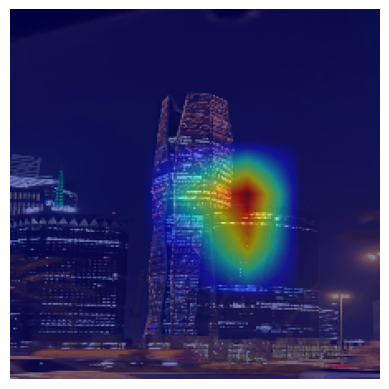

In [14]:
import cv2 # Import OpenCV for image operations

# Redefine the grad_cam function with the fix
def grad_cam(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img = tf.keras.preprocessing.image.img_to_array(img)/255
    img = np.expand_dims(img,0)

    # Corrected grad_model definition:
    # We need to get the output of the ResNet50 base_model as it flows through the main model.
    # This is the input to the 'reshape' layer in our model definition.
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer('reshape').input, model.output] # Use input of 'reshape' layer
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    heatmap = tf.reduce_mean(grads, axis=-1)[0]
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    return heatmap

img_path = image_paths[0]   # any image
heatmap = grad_cam(img_path)

img = cv2.imread(img_path)
img = cv2.resize(img,(224,224))

plt.imshow(img[:,:,::-1])
plt.imshow(cv2.resize(heatmap,(224,224)), alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()


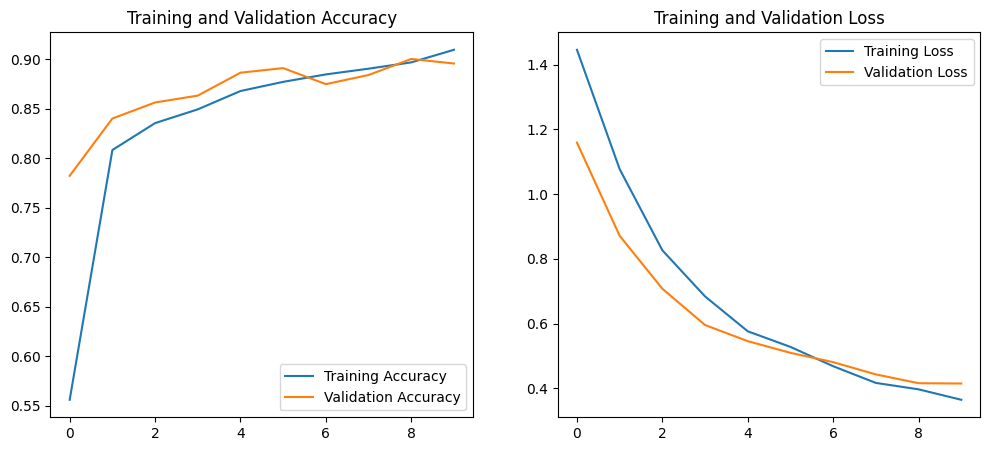

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.show()

plot_history(history)

In [ ]:
# Load the weights from the 10th epoch
model.load_weights('weights_epoch_10.weights.h5')
print("✅ Weights from epoch 10 loaded successfully!")

✅ Weights from epoch 10 loaded successfully!


In [ ]:
# Continue training for 5 more epochs (total of 15)
history_continued = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,             # The final goal
    initial_epoch=10,      # Where we left off
    class_weight=class_weight_dict,
    callbacks=callbacks + [DynamicClassWeight()]
)

print("\n✅ Training Complete! Total epochs reached: 15")

Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 6s/step

Dynamic class weights: {0: np.float64(1.078201306526289), 1: np.float64(1.0454175862469508), 2: np.float64(1.0720202709287594), 3: np.float64(1.0480807022140706), 4: np.float64(1.2014533242621195)}
54/54 ━━━━━━━━━━━━━━━━━━━━ 756s 12s/step - accuracy: 0.8989 - loss: 0.3506 - val_accuracy: 0.9005 - val_loss: 0.4118
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step

Dynamic class weights: {0: np.float64(1.0613722919398139), 1: np.float64(1.0702818408847663), 2: np.float64(1.0720202709287594), 3: np.float64(1.0480807022140706), 4: np.float64(1.1928200853656785)}
54/54 ━━━━━━━━━━━━━━━━━━━━ 702s 11s/step - accuracy: 0.8932 - loss: 0.3623 - val_accuracy: 0.9005 - val_loss: 0.4204
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 6s/step

Dynamic class weights: {0: np.float64(1.1512155481817565), 1: np.float64(1.0454175862469508), 2: np.float64(1.1269337158078065), 3: np.float64(1.0655301012253595), 4: np.float64(1.151450411331382)}
54/54 ━━━━━━━━━

In [ ]:
# Load best epoch weights
model.load_weights("weights_epoch_13.weights.h5")   # change if another epoch is best
print("✅ Best weights loaded")


✅ Best weights loaded


In [17]:
import numpy as np

y_true = []
y_pred = []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [18]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print("Overall Test Accuracy:", acc)


Overall Test Accuracy: 0.8909090909090909


In [19]:
from sklearn.metrics import classification_report

class_names = ["Tree","Car","Building","Person","Lab"]

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


              precision    recall  f1-score   support

        Tree     0.8667    0.8864    0.8764        44
         Car     0.8913    0.9318    0.9111        44
    Building     0.9302    0.9091    0.9195        44
      Person     0.9524    0.9091    0.9302        44
         Lab     0.8182    0.8182    0.8182        44

    accuracy                         0.8909       220
   macro avg     0.8918    0.8909    0.8911       220
weighted avg     0.8918    0.8909    0.8911       220



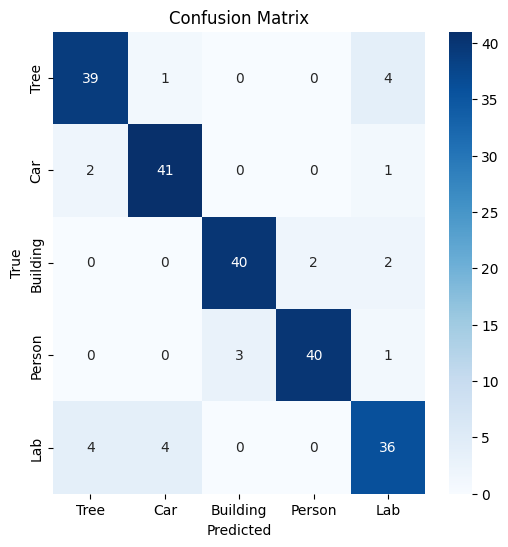

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


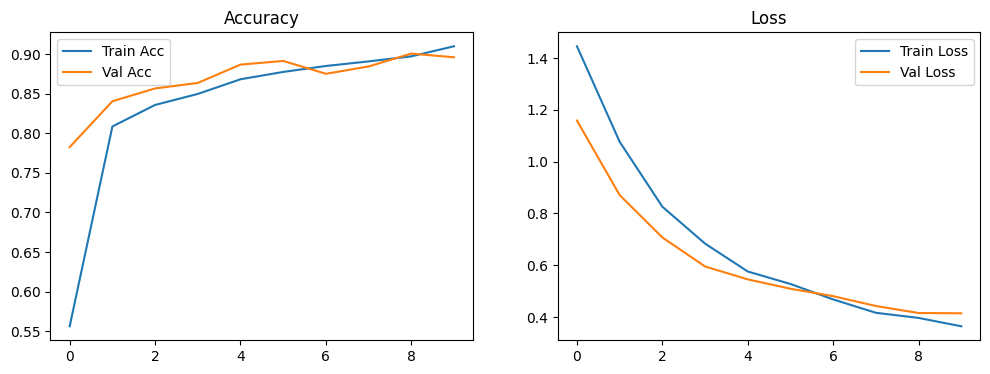

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

resnet = model.get_layer("resnet50")

grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[resnet.output, model.output]
)

print("Grad-CAM backbone ready")


Grad-CAM backbone ready


In [ ]:
img_path = image_paths[5]

raw = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(raw, channels=3)
img = tf.image.resize(img, (224,224))
img = tf.cast(img, tf.float32)/255.0
img_array = tf.expand_dims(img, axis=0)

In [ ]:
with tf.GradientTape() as tape:
    conv_out, preds = grad_model(img_array)
    class_idx = tf.argmax(preds[0])
    loss = preds[:, class_idx]

grads = tape.gradient(loss, conv_out)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
conv_out = conv_out[0]

heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

heatmap = heatmap.numpy()
print("Predicted:", class_names[int(class_idx)])

KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m137373220372560\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)\n  • training=None\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

In [ ]:
orig = cv2.imread(img_path)
orig = cv2.resize(orig, (224,224))

hm = cv2.resize(heatmap, (224,224))
hm = np.uint8(255 * hm)
hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

superimposed = cv2.addWeighted(orig, 0.6, hm, 0.4, 0)

plt.imshow(superimposed[:,:,::-1])
plt.axis("off")
plt.show()

In [ ]:
print(model.inputs)

[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_175>]


In [ ]:
import numpy as np
import tensorflow as tf
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Access the ResNet50 base layer from your Sequential model
    base_model = model.get_layer('resnet50')

    # 2. Build the gradient model using the internal layers of the base
    grad_model = tf.keras.models.Model(
        inputs=[base_model.input],
        outputs=[base_model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 3. Handle the input flow through the augmentation layer manually if needed
    # but for validation images, we can pass them directly to the grad_model
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 4. Standard Grad-CAM math
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

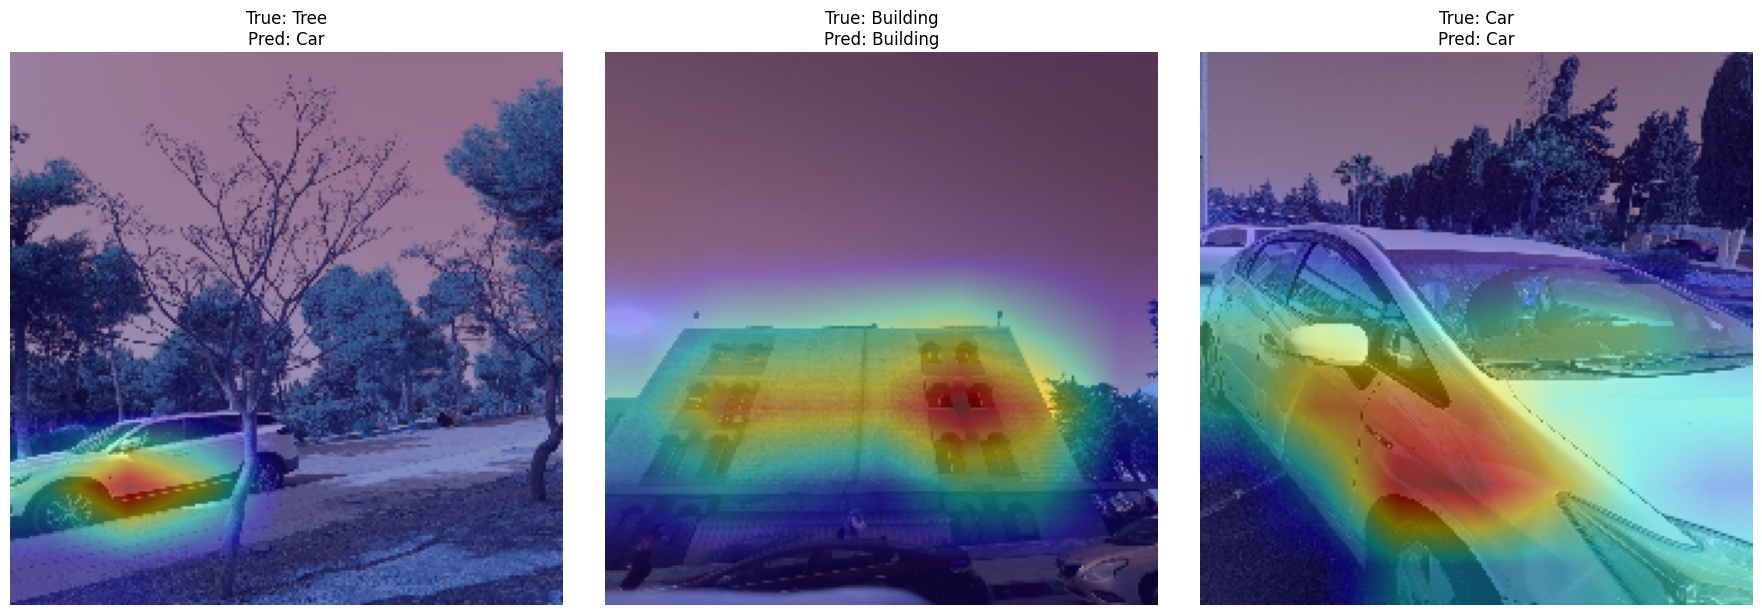

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def get_gradcam_on_dataset(dataset, model, last_conv_layer_name, num_samples=3):
    # 1. Isolate the ResNet base model specifically
    # In your Sequential model, this is the layer named 'resnet50'
    base_model = model.get_layer('resnet50')

    # 2. Build the Grad-CAM model using ONLY the base_model's internal logic
    # This avoids the Sequential/Augmentation layers that cause the error
    grad_model = tf.keras.models.Model(
        inputs=[base_model.input],
        outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    # 3. Create a second 'Prediction Head' model to get the final class scores
    # This takes the output of the ResNet base and runs it through your Dense layers
    # We find where the Dense layer is in your Sequential model (usually at the end)
    prediction_head = tf.keras.Sequential(model.layers[model.layers.index(base_model)+1:])

    for images, labels in dataset.take(1):
        plt.figure(figsize=(18, 6))

        for i in range(min(num_samples, len(images))):
            img_single = tf.expand_dims(images[i], axis=0)

            with tf.GradientTape() as tape:
                # Flow the image through the base model
                conv_outputs, base_preds = grad_model(img_single)
                # Flow the base output through the custom head to get final class prediction
                final_preds = prediction_head(base_preds)

                class_idx = tf.argmax(final_preds[0])
                loss = final_preds[:, class_idx]

            # Calculate gradients
            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

            # Heatmap math
            conv_outputs = conv_outputs[0]
            heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
            heatmap = heatmap.numpy()

            # --- DISPLAY LOGIC ---
            img_display = images[i].numpy()
            img_display -= img_display.min()
            img_display /= (img_display.max() + 1e-10)

            heatmap_rescaled = np.uint8(255 * heatmap)
            heatmap_rescaled = cv2.resize(heatmap_rescaled, (224, 224))
            heatmap_color = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)
            heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

            superimposed = np.uint8(heatmap_color * 0.4 + (img_display * 255 * 0.6))

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(superimposed)
            plt.title(f"True: {unique_classes[labels[i]]}\nPred: {unique_classes[class_idx]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# RUN THIS
get_gradcam_on_dataset(val_ds, model, "conv5_block3_out")